## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.multioutput import RegressorChain
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
from sklearn import __version__
__version__

'1.0.2'

## Variables de Control

In [3]:
SHOULD_SAMPLE = False
SAMPLE_PER = 0.25
DATASET_NAME = 'Yakutia'
TRAIN_MODELS = False
N_FOLDS = 10
RAND_STATE = 42
TEST_SIZE = 0.2
REMOVE_COLUMNS = True
GRIDSEARCH = False
POST_GS = False
N_REPEATS = 3

### Modelos

In [4]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, tol=1e-3, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

## Funciones

In [5]:
def load_pickle(filename: str):
    infile = open(filename, 'rb')
    var = pickle.load(infile, encoding='latin1')
    infile.close()
    return var

def save_to_pickle(filename: str, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def squash(df):
    df_dict = {}
    for x in range(df.shape[0]):
        serie = df.iloc[x,:]
        for index, value in serie.items():
            df_dict.update({f'{serie.name} {index}': f'{value}'})
            
    return pd.DataFrame.from_dict(df_dict, orient='index').T

## Carga de datos

In [6]:
df = pd.read_csv('./data/Yakutia.csv', index_col=0)
df.head().T

,0,1,2,3,4
Load AC Load pini,0.0252,0.0225,0.0199,0.0188,0.0194
Load AC Load terminal,T-1,T-1,T-1,T-1,T-1
Load AC Load voltage,1.0000,1.0000,1.0000,1.0000,1.0000
ConventionalGenerator DG1 pini,0.0139,0.0124,0.0089,0.0033,0.0033
ConventionalGenerator DG1 voltage,1.0000,1.0000,1.0000,1.0000,1.0000
ConventionalGenerator DG1 loading,0.0252,0.0228,0.0177,0.0112,0.0112
ConventionalGenerator DG1 cst_disp,-0.1376,-0.1383,-0.1399,-0.1425,-0.1425
ConventionalGenerator DG1 terminal,T-0,T-0,T-0,T-0,T-0
ConventionalGenerator DG2 pini,0.0000,0.0000,0.0000,0.0000,0.0000
ConventionalGenerator DG2 voltage,1.0000,1.0000,1.0000,1.0000,1.0000


## Preprocesado

In [7]:
df.shape

(70024, 41)

In [8]:
df = df.drop_duplicates()
df.shape

(48109, 41)

## Análisis

### Descripción estadística

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Load AC Load pini,48109.0000,0.0286,0.0094,0.0158,0.0225,0.0264,0.0303,0.0720
Load AC Load voltage,48109.0000,1.0000,0.0000,0.9999,1.0000,1.0000,1.0000,1.0001
ConventionalGenerator DG1 pini,23952.0000,-0.1089,6.0766,-39.9567,0.0000,0.0154,0.0252,32.3609
ConventionalGenerator DG1 voltage,23952.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
ConventionalGenerator DG1 loading,23952.0000,3.4655,9.5180,0.0097,0.0138,0.0323,0.0569,66.5945
ConventionalGenerator DG1 cst_disp,23952.0000,-0.2158,2.8483,-19.6253,-0.1440,-0.1369,-0.1323,14.2911
ConventionalGenerator DG2 pini,35966.0000,-0.0774,4.9580,-39.9567,0.0000,0.0000,0.0000,30.0000
ConventionalGenerator DG2 voltage,35966.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
ConventionalGenerator DG2 loading,35966.0000,4.5977,15.8764,0.0000,0.0000,0.0000,0.0530,133.1889
ConventionalGenerator DG2 cst_disp,35966.0000,-0.1110,2.5731,-23.5462,-0.0185,-0.0185,-0.0185,13.0641


In [10]:
df.describe().T.drop(columns=['count']).to_latex('{}_stats.tex'.format(DATASET_NAME))

### Matriz de valores faltantes

<AxesSubplot:>

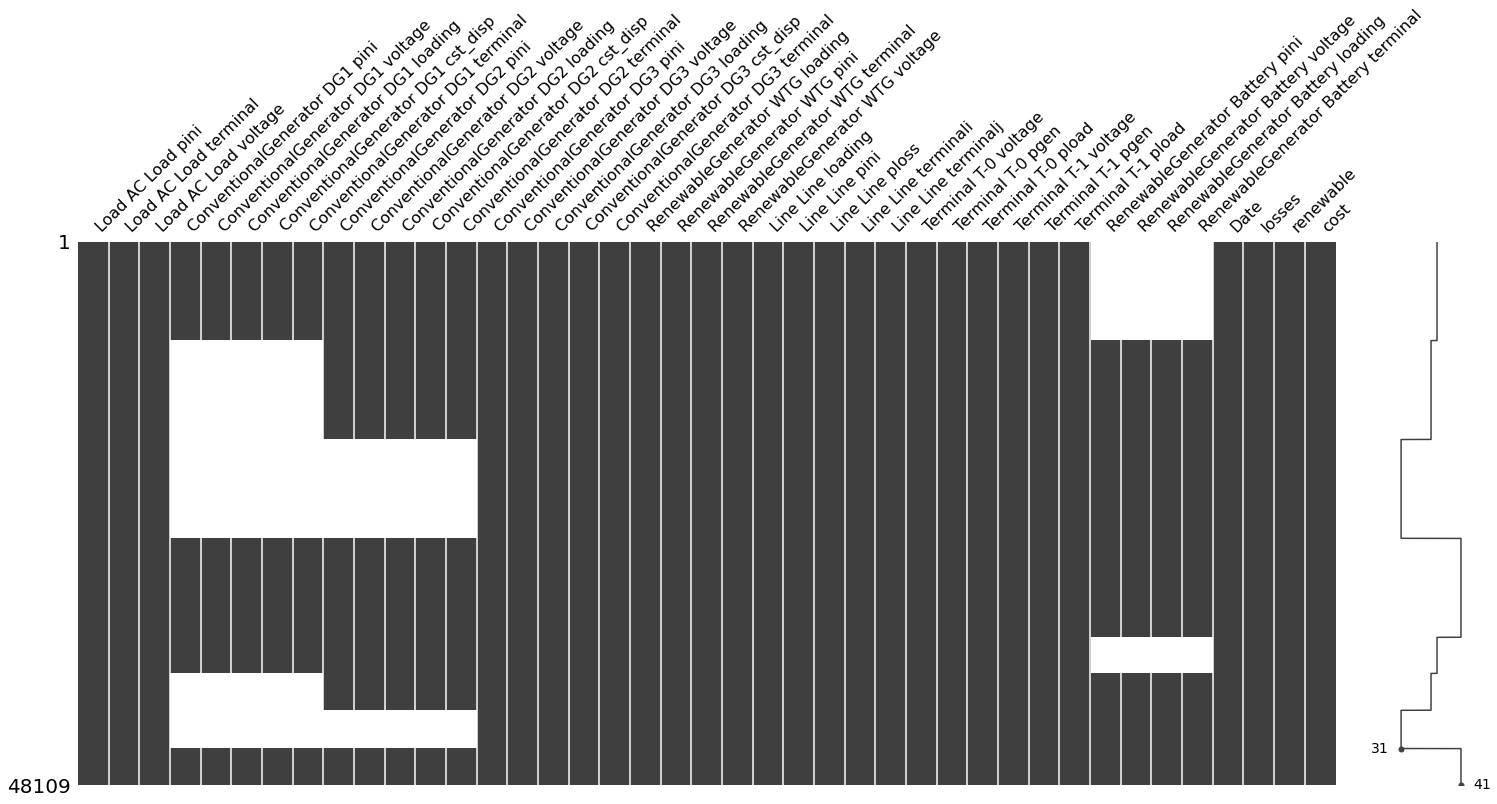

In [11]:
msno.matrix(df)

### Dendrograma de valores faltantes

<AxesSubplot:>

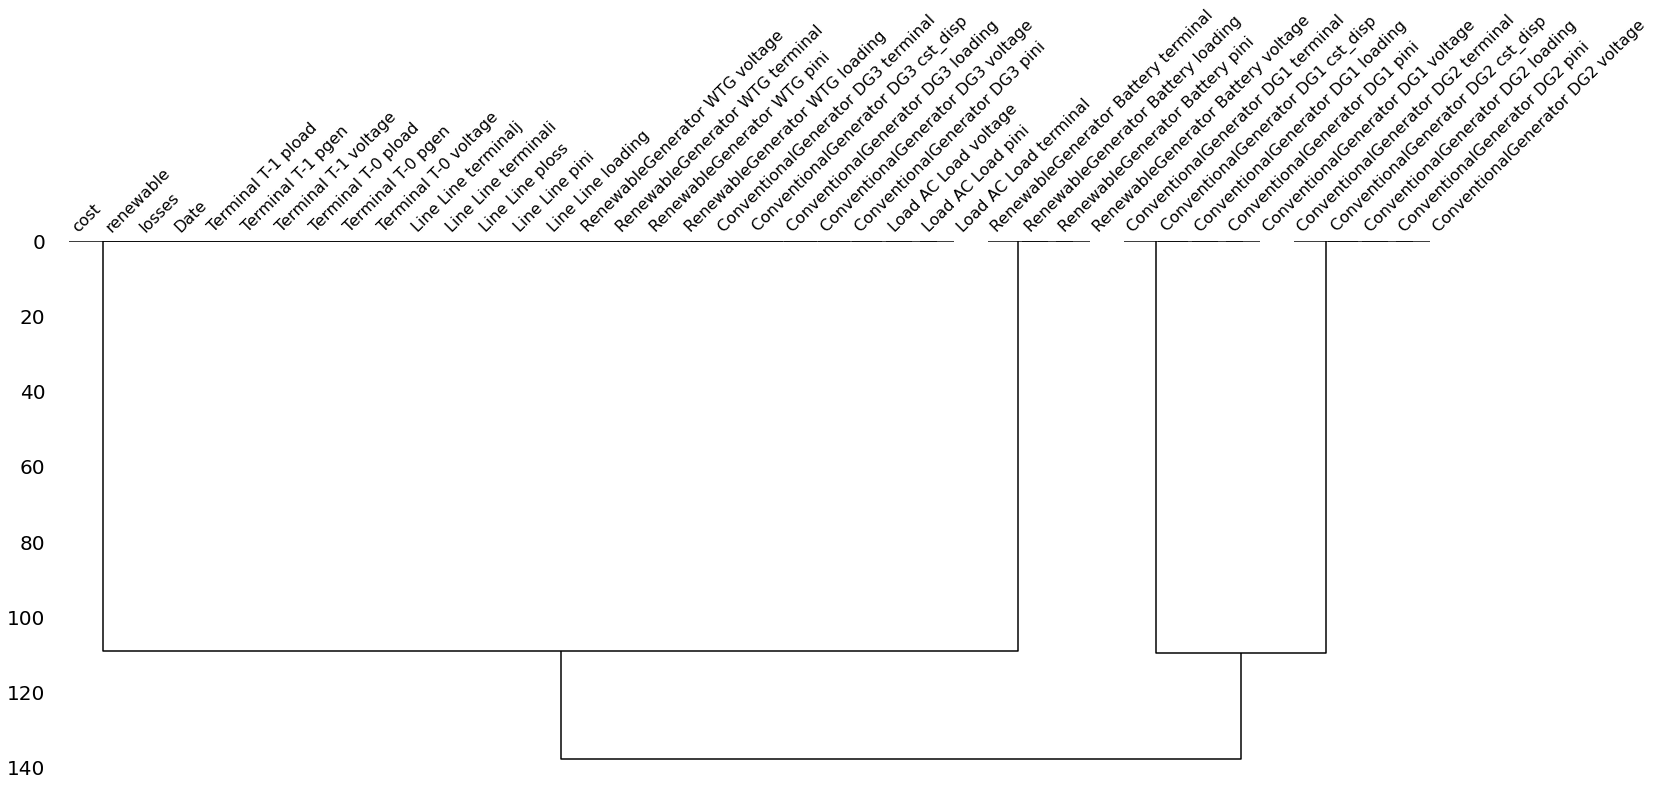

In [12]:
msno.dendrogram(df)

### Correlación entre valores faltantes

<AxesSubplot:>

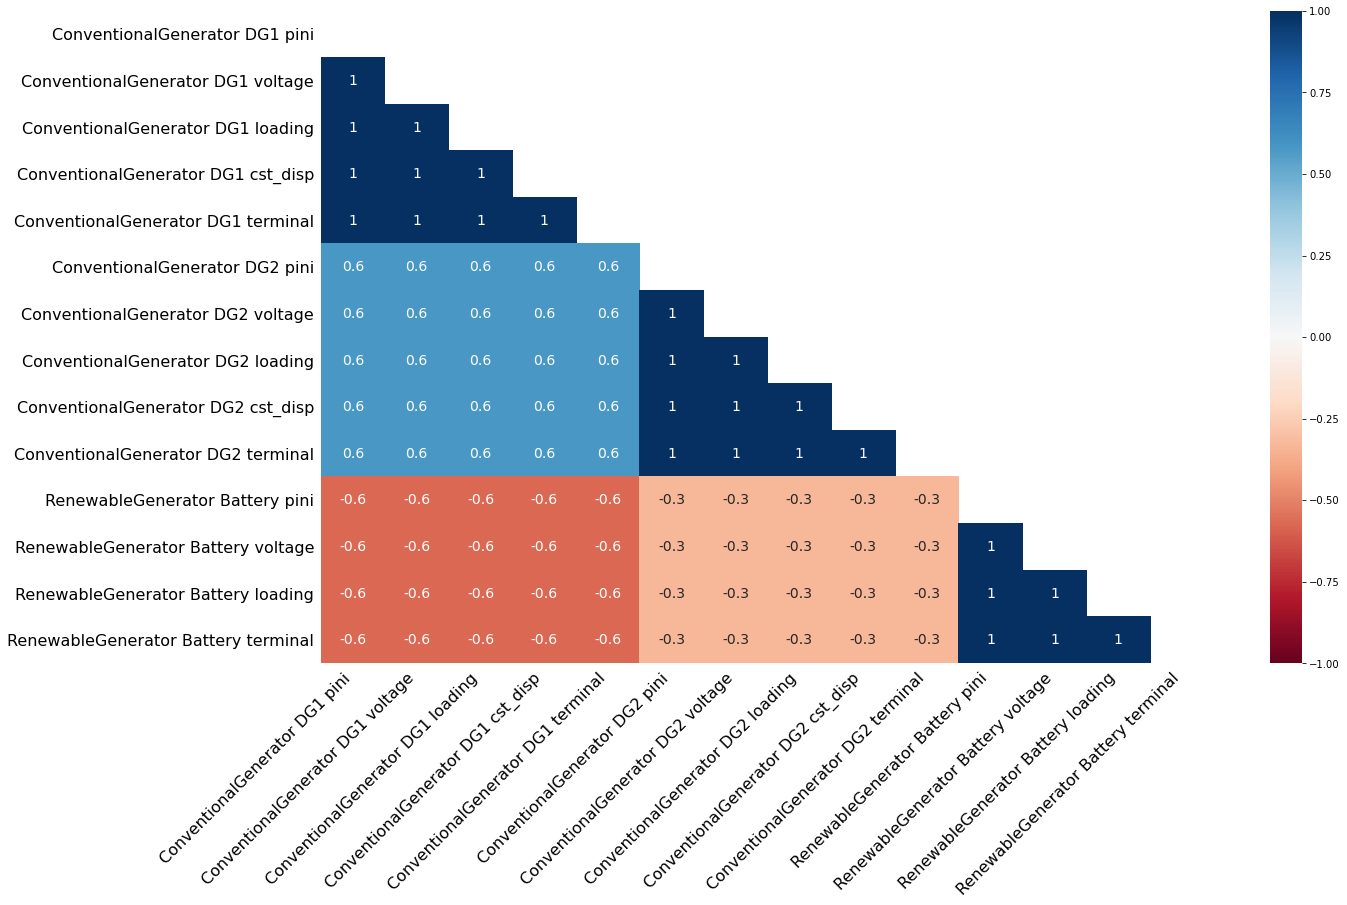

In [13]:
msno.heatmap(df)

### Procesado de valores faltantes

Valores faltantes reemplazados por valor neutro de los campos (0)

In [14]:
df = df.replace(np.NaN, 0)

Se compreuba que el dataset está completo (No hay valores faltantes)

<AxesSubplot:>

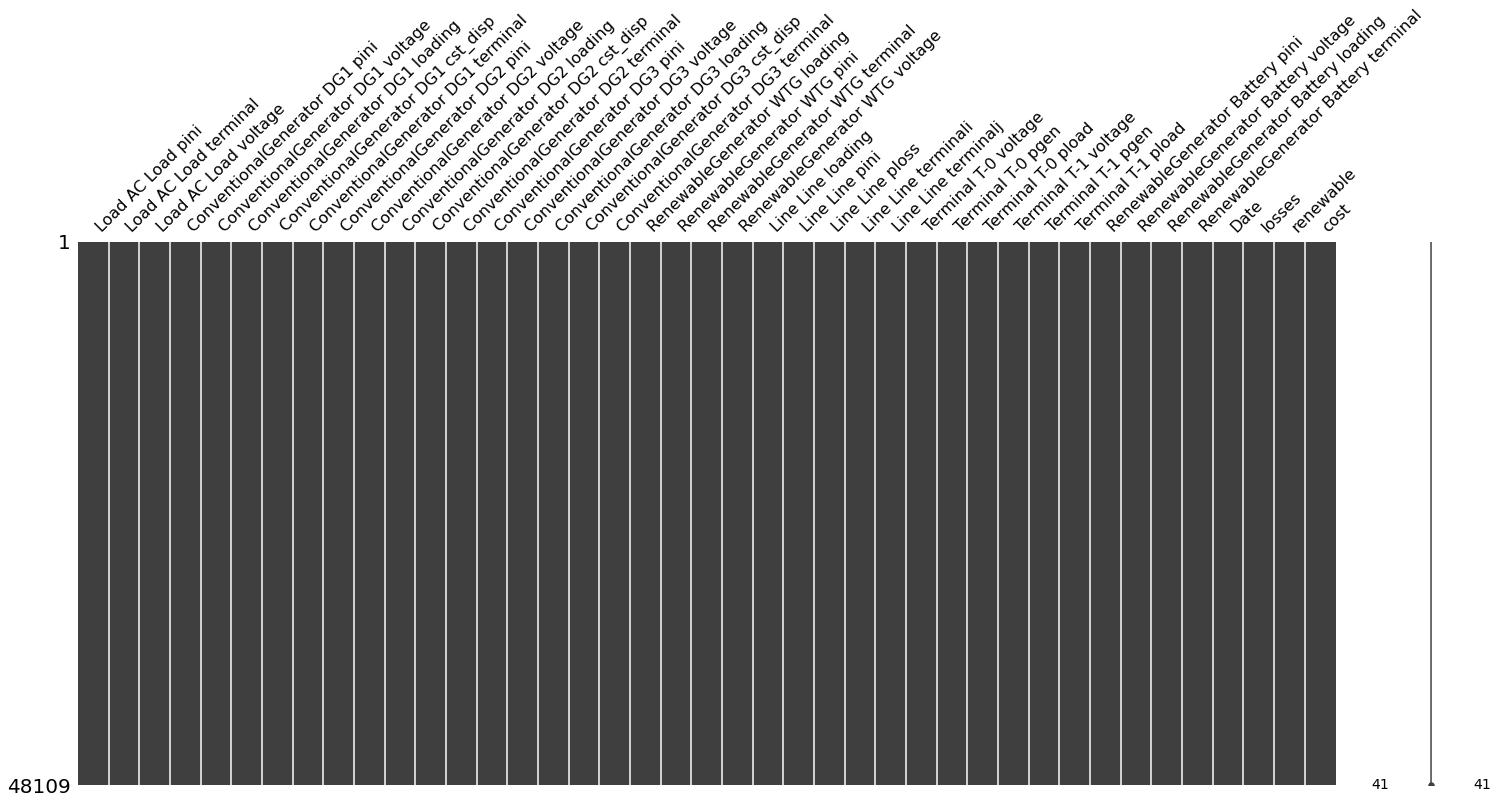

In [15]:
msno.matrix(df)

### Eliminación de columnas con baja varianza

In [16]:
df.shape

(48109, 41)

In [17]:
selector = VarianceThreshold()
columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])
selector.fit(df.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in df.columns if 'terminal' in x]))

VarianceThreshold()

In [18]:
selected_columns = list()
removed_columns = list()
for column, selected in zip(columns, selector.get_support()):
    if selected:
        selected_columns.append(column)
    else:
        removed_columns.append(column)

print('Columnas removidas por baja varianza:\n', removed_columns)

Columnas removidas por baja varianza:
 ['ConventionalGenerator DG3 voltage', 'Terminal T-0 voltage', 'Terminal T-0 pload']


In [19]:
if REMOVE_COLUMNS:
    df = df.drop(columns=removed_columns)
    df.shape

### Correlación entre valores del datase

In [20]:
corr_df = df.drop(columns=['losses', 'renewable', 'cost']).corr().round(decimals=2).dropna(how='all', axis=1).dropna(how='all', axis=0)

In [21]:
corr_df.shape

(26, 26)

<AxesSubplot:>

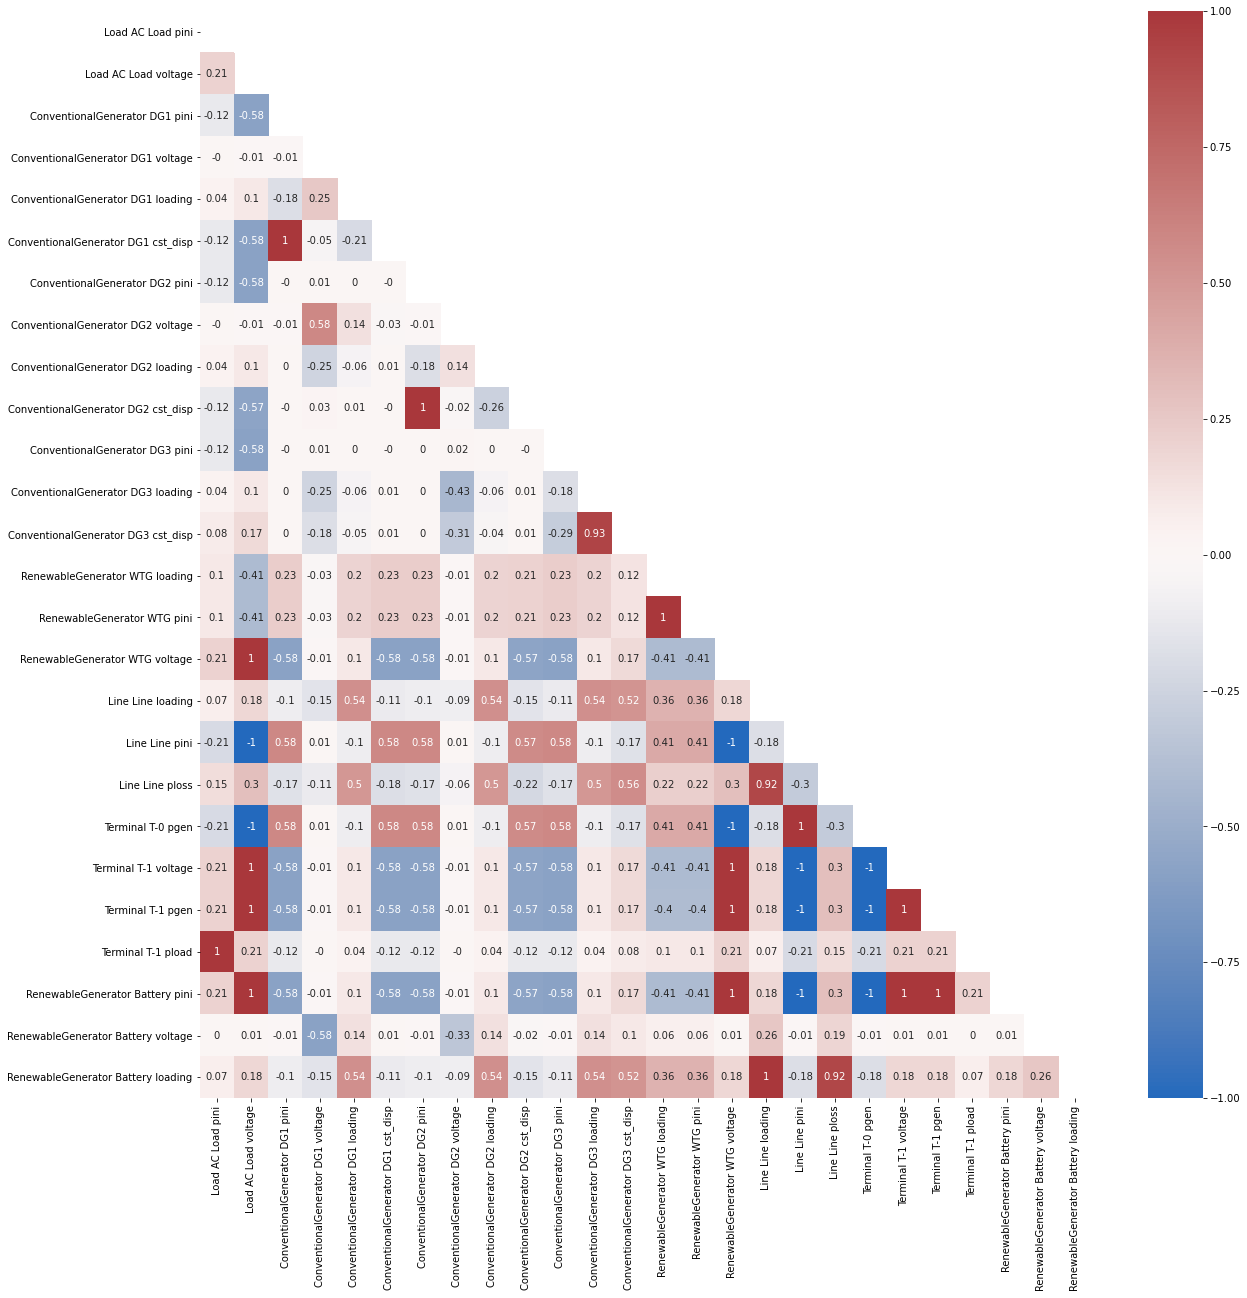

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, ax=ax, annot=True, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True))

In [23]:
#figure, axis = plt.subplots(5, 6, figsize=(20,20))
#columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])

#for i in range(0,5):
#    for j in range(0,6):
#        sns.histplot(df, x=columns[i * 5 + j], bins=20, ax=axis[i, j])

#plt.show()


## Modelado

In [24]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if TRAIN_MODELS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    save_to_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME))

#### Puntaje medio obtenido en validación cruzada, hiperparámetros predeterminados

In [25]:
model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)
model_scores_df

,SGD,Linear,SVR,RandomForest,GradientBoosting,MLP
fit_time,0.2958,0.3133,9.5180,50.9720,61.8222,2.8507
score_time,0.0138,0.0157,0.9254,0.1316,0.0284,0.0109
test_explained_variance,0.6655,0.7751,0.5923,0.9980,0.9997,-1571645.1368
test_neg_mean_squared_error,-0.0149,-0.0122,-0.0052,-0.0000,-0.0000,-0.0009
test_r2,0.6654,0.7750,-36.3577,0.9980,0.9997,-1666394.5484


In [26]:
filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

In [27]:
test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test, scoring='neg_mean_squared_error'))



TypeError: score() got an unexpected keyword argument 'scoring'

### Resultados

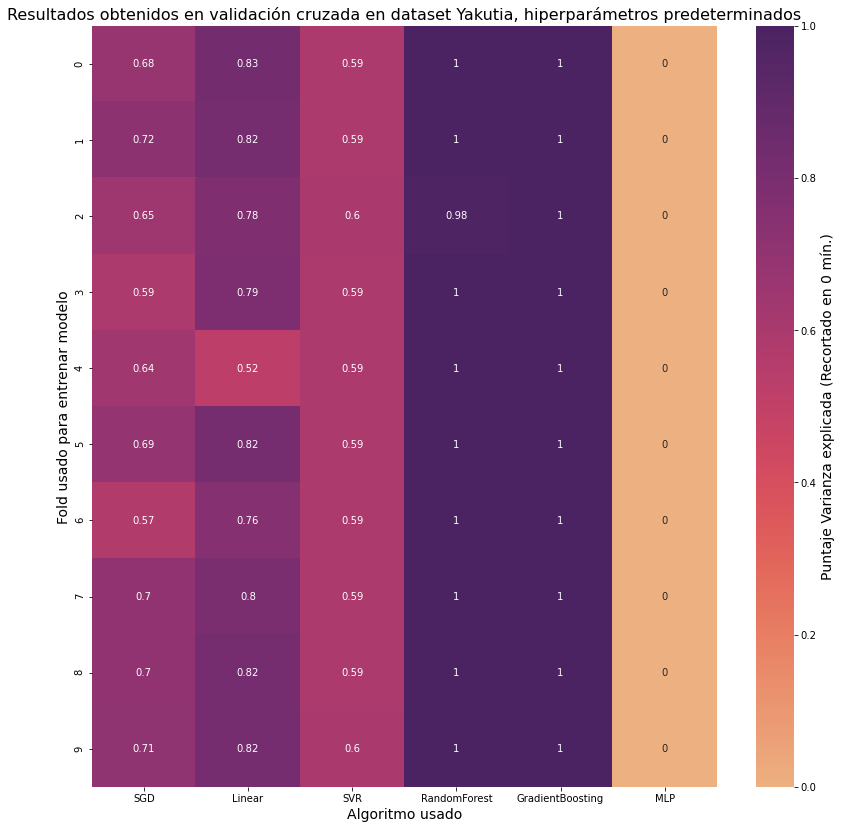

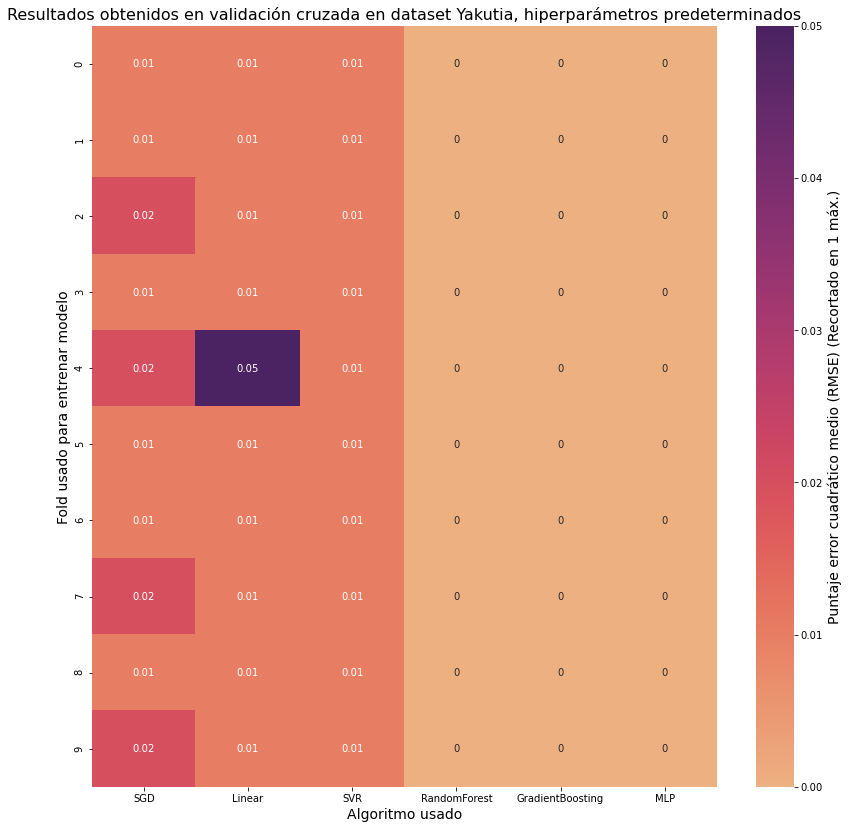

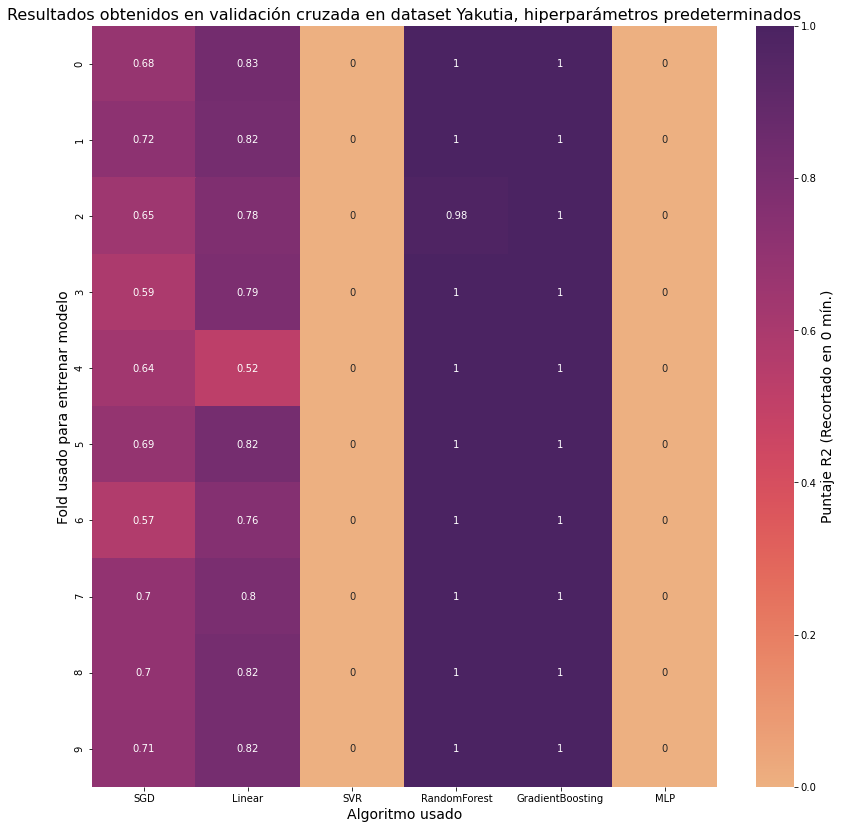

In [ ]:
test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                   'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                   'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados obtenidos en validación cruzada en dataset {}, hiperparámetros predeterminados'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Fold usado para entrenar modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

In [ ]:
test_scores_df = pd.DataFrame.from_dict(test_scores)
test_scores_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SGD,10.0000,0.7115,0.0155,0.6862,0.7018,0.7177,0.7220,0.7258
Linear,10.0000,0.8336,0.0024,0.8321,0.8325,0.8328,0.8335,0.8403
SVR,10.0000,-27.1857,0.0043,-27.1922,-27.1886,-27.1851,-27.1841,-27.1785
RandomForest,10.0000,1.0000,0.0000,0.9999,0.9999,1.0000,1.0000,1.0000
GradientBoosting,10.0000,0.9998,0.0000,0.9998,0.9998,0.9998,0.9998,0.9998
MLP,10.0000,-1302905.2222,681004.8012,-2874371.3168,-1434954.5510,-1004066.7216,-841269.1098,-794403.8384


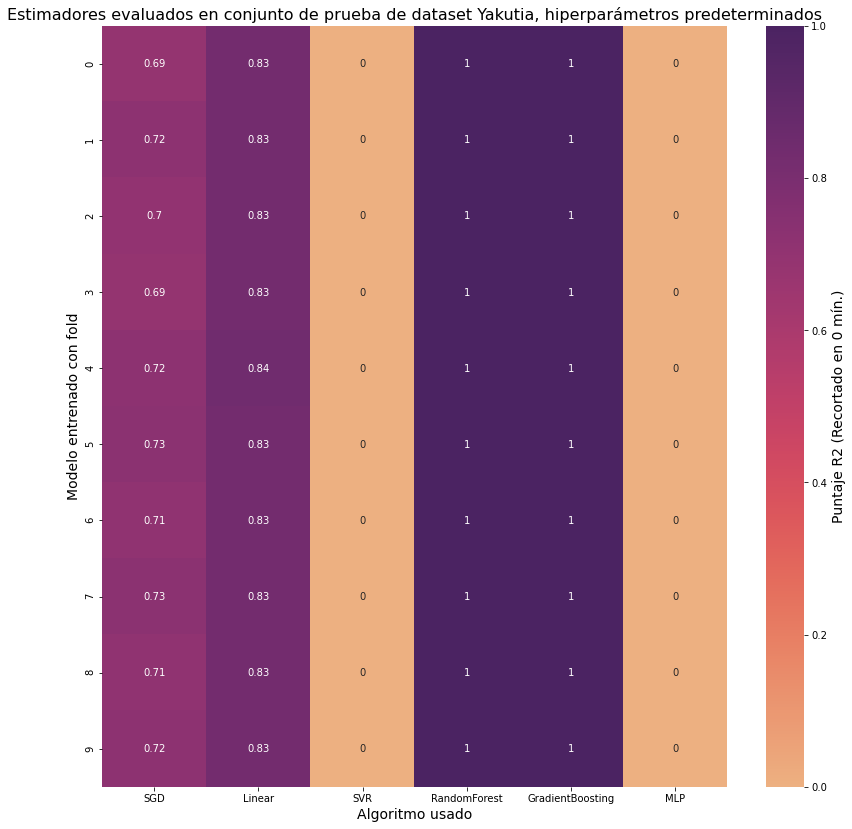

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.apply(lambda x: x.apply(lambda y: -y)).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje error cuadrático medio (RMSE)'})
ax.set_title('Estimadores evaluados en conjunto de prueba de dataset {}, hiperparámetros predeterminados'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Modelo entrenado con fold', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()

### Grid Search

In [ ]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

In [ ]:
# Spaces
hyper_spaces = {
    'SGD': {
        'base_estimator__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'base_estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'base_estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    },
    'Linear': {
        'base_estimator__fit_intercept': [True, False]
    },
    'SVR': {
        'base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__gamma': ['scale', 'auto'],
         'base_estimator__C': [0.1, 1, 10, 100]
    },
    'RandomForest': {
        'n_estimators': [10, 50, 100, 200, 400],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 10, 100, 200],
    },
    'GradientBoosting': {
        'base_estimator__loss': ['ls', 'lad', 'huber', 'quantile'],
        'base_estimator__learning_rate': [0.01, 0.1, 1],
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__criterion': ['friedman_mse', 'mse', 'mae']
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (20,), (40,), (10, 10,), (20, 10), (40, 10,)],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'activation': ['logistic', 'tanh'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'batch_size': ['auto', 50, 100, 200, 400]
    }
}

if GRIDSEARCH:
    cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=RAND_STATE)
    X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
    y = dataset[['losses', 'renewable', 'cost']]

    results_dfs = {}

    for name, model in estimators.items():
        start_time = time.time()
        search = GridSearchCV(model, hyper_spaces[name], scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
        result = search.fit(X, y)
        results_dfs[name] = pd.DataFrame.from_dict(result.cv_results_)
        results_dfs[name].to_csv('{}_{}_HyperScores.csv'.format(DATASET_NAME, name))
        print('{}:\nMejor puntaje: {}\nMejor Hiperparámetros: {}\nTiempo: {} s'.format(name, result.best_score_, result.best_params_, (time.time() - start_time)))

else:
    print('GridSearch omitido.')


GridSearch omitido.


In [ ]:
if GRIDSEARCH:
    for name, model in estimators.items():
        cols = [x for x in results_dfs[name].columns if 'param_' in x]
        cols.append('mean_test_score')
        print(name)
        display(results_dfs[name][cols])
else:
    print('GridSearch omitido.')

GridSearch omitido.


## Entrenamiento de modelos con hiperparámetros óptimos

In [ ]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE, learning_rate='adaptive', loss='huber', penalty='l1'), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(fit_intercept=False), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(C=1, epsilon=0.1, kernel='poly'), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE, criterion='squared_error', max_depth=200, n_estimators=400),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE, criterion='friedman_mse', learning_rate=1, loss='squared_error', n_estimators=200), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE, activation='logistic', hidden_layer_sizes=(20,), learning_rate='constant', solver='lbfgs')}

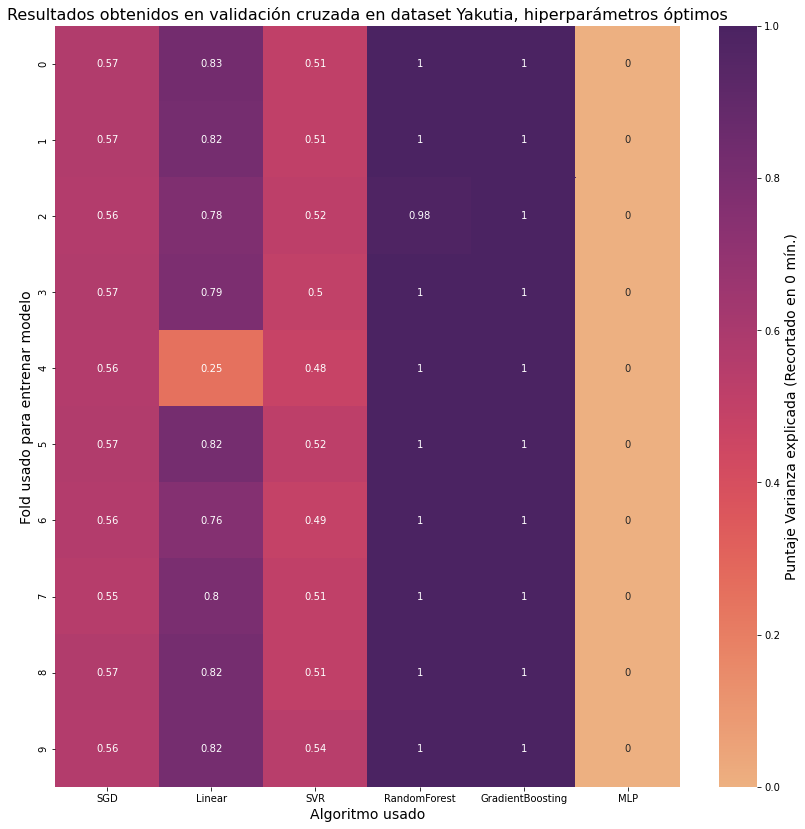

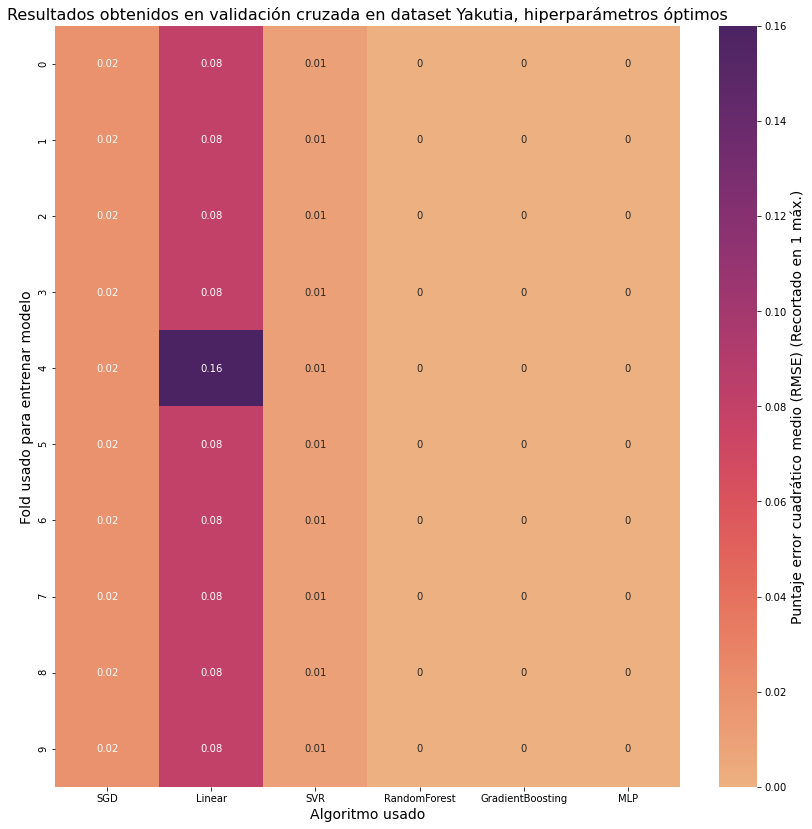

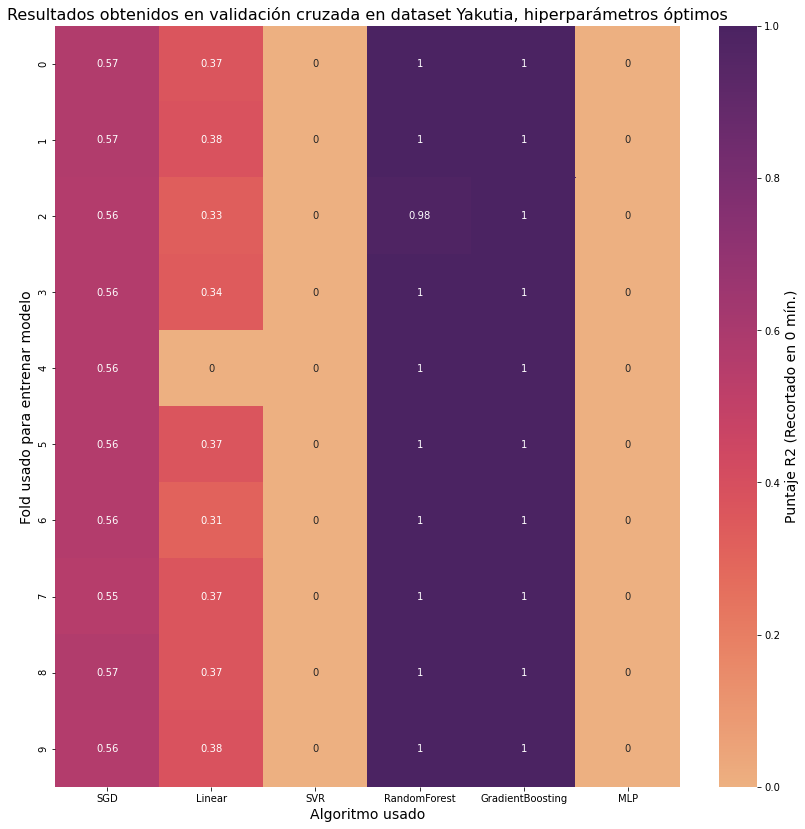

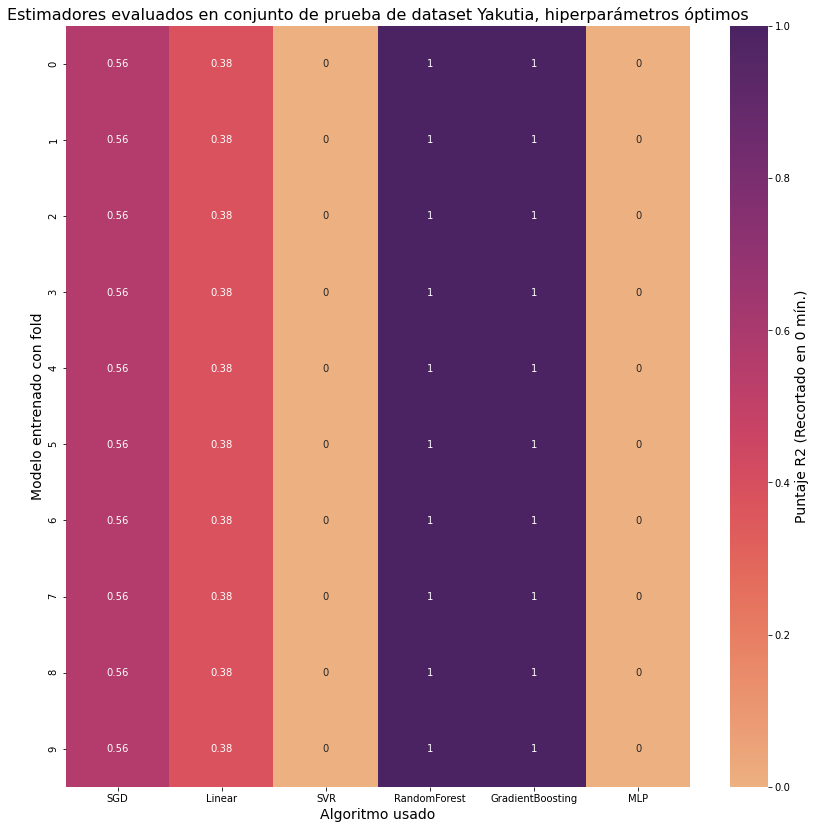

In [ ]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if POST_GS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    
    save_to_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME)) 

model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)

filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test, scoring='neg_mean_squared_error'))

test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados obtenidos en validación cruzada en dataset {}, hiperparámetros óptimos'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Fold usado para entrenar modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

test_scores_df = pd.DataFrame.from_dict(test_scores)

fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.apply(lambda x: x.apply(lambda y: -y)).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje error cuadrático medio (RMSE)'})
ax.set_title('Estimadores evaluados en conjunto de prueba de dataset {}, hiperparámetros óptimos'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Modelo entrenado con fold', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()


In [ ]:
opt_test_scores_mean = test_scores_df.mean()
opt_test_scores_mean

SGD                      0.5643
Linear                   0.3829
SVR                    -27.2401
RandomForest             1.0000
GradientBoosting         0.9998
MLP                -257475.8026
dtype: float64

## Interpretabilidad

In [ ]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

### Linear

In [ ]:
# modelo linear, importancia de atributos

linear_estimator = model_scores['Linear']['estimator'][0]
linear_estimator.estimators_[0].coef_

array([ 1.08740566e+05,  1.38163789e+04, -1.23848035e+06, -5.25265833e-06,
       -4.30100461e-02, -1.46856152e-04, -1.23820204e+06, -1.35952709e-07,
       -4.30106730e-02, -4.31206993e-05, -1.23944803e+06, -4.30531746e-02,
        3.75624283e-06, -6.07263696e+04,  5.97161878e+04, -9.94948029e+03,
        6.23741188e-02, -2.13774486e+04, -2.19861711e-02,  2.18535150e+06,
        1.38600483e+04,  5.76303107e+05, -1.08741777e+05, -5.75757438e+05,
       -1.75350374e-07,  7.41453659e-03])

In [ ]:
pad_coefs = list()
for estimator in linear_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))


Se considera el orden de magnitud de cada coeficiente para comparar la relevancia de cada atributo. Se considera que el atributo no tiene relevancia para la predicción si el orden de magnitud es menor que cero.

In [ ]:
linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
linear_coefs_df = linear_coefs_df.apply(lambda x: np.log10(np.maximum(np.abs(x), 1)))
linear_coefs_df

,losses,renewable,cost
Load AC Load pini,5.0364,11.2437,6.4157
Load AC Load voltage,4.1404,10.2936,5.6227
ConventionalGenerator DG1 pini,6.0929,12.3046,9.1341
ConventionalGenerator DG1 voltage,0.0000,0.0000,0.0000
ConventionalGenerator DG1 loading,0.0000,4.5818,2.9751
ConventionalGenerator DG1 cst_disp,0.0000,0.0000,0.0000
ConventionalGenerator DG2 pini,6.0928,12.3045,9.1340
ConventionalGenerator DG2 voltage,0.0000,0.0000,0.0000
ConventionalGenerator DG2 loading,0.0000,4.5818,2.9751
ConventionalGenerator DG2 cst_disp,0.0000,0.0000,0.0000


### Random Forest

In [ ]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)

In [ ]:
rforest_estimator = model_scores['RandomForest']['estimator'][0]
rforest_estimator.feature_importances_

array([3.37424393e-05, 2.77288464e-01, 2.76762184e-06, 2.09928040e-07,
       2.67912922e-06, 3.21247653e-06, 1.98812787e-06, 1.11032356e-06,
       1.89737784e-06, 2.20173023e-06, 2.30127514e-03, 2.71252996e-03,
       2.05823020e-03, 9.11586227e-03, 9.65398976e-03, 2.88138177e-01,
       3.35476716e-03, 4.70251807e-03, 7.01068897e-04, 5.18116908e-03,
       2.91647922e-01, 1.02533955e-01, 3.25385472e-05, 2.86649554e-04,
       9.16657414e-05, 1.49409538e-04])

Se considera importancia de cada atributo. Mientras mayor el valor, más importante es. Este valor corresponde a Gini Importance / Mean Decrease in Impurity (MDI)

In [ ]:
#linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
forest_importance_df = pd.DataFrame([rforest_estimator.feature_importances_], columns=X_cols).T
forest_importance_df

,0
Load AC Load pini,0.0000
Load AC Load voltage,0.2773
ConventionalGenerator DG1 pini,0.0000
ConventionalGenerator DG1 voltage,0.0000
ConventionalGenerator DG1 loading,0.0000
ConventionalGenerator DG1 cst_disp,0.0000
ConventionalGenerator DG2 pini,0.0000
ConventionalGenerator DG2 voltage,0.0000
ConventionalGenerator DG2 loading,0.0000
ConventionalGenerator DG2 cst_disp,0.0000


Debido a la diferencia de ordenes de magnitud en la importancia que se le otroga a cada atributo, se hace esta comparación también. Valores mayores son mejores.

In [ ]:
forest_importance_magnitude_df = forest_importance_df.apply(lambda x: np.log10(np.abs(x)))
forest_importance_magnitude_df

,0
Load AC Load pini,-4.4718
Load AC Load voltage,-0.5571
ConventionalGenerator DG1 pini,-5.5579
ConventionalGenerator DG1 voltage,-6.6779
ConventionalGenerator DG1 loading,-5.5720
ConventionalGenerator DG1 cst_disp,-5.4932
ConventionalGenerator DG2 pini,-5.7016
ConventionalGenerator DG2 voltage,-5.9546
ConventionalGenerator DG2 loading,-5.7218
ConventionalGenerator DG2 cst_disp,-5.6572


### Gradient Boosting

In [ ]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [ ]:
gboost_estimator = model_scores['GradientBoosting']['estimator'][1]
gboost_estimator.estimators_[2].feature_importances_

array([7.13994007e-06, 7.19633837e-04, 2.44208800e-04, 0.00000000e+00,
       6.20439072e-07, 9.68364493e-05, 1.81796607e-04, 4.95086269e-07,
       8.60699823e-05, 3.12213961e-04, 1.28826174e-02, 7.63285250e-01,
       4.70828431e-04, 7.09690847e-07, 1.31734874e-06, 1.09081245e-03,
       1.37880704e-02, 1.04131043e-03, 2.78786925e-02, 6.37364613e-03,
       1.58242307e-02, 1.53644881e-01, 5.76665747e-06, 1.52777139e-03,
       2.00816136e-04, 3.34264438e-04, 0.00000000e+00, 0.00000000e+00])

In [ ]:
pad_coefs = list()
for estimator in gboost_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.feature_importances_, (0, col_length - len(estimator.feature_importances_)), mode='constant', constant_values=0))

In [ ]:
gboost_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
gboost_coefs_df

,losses,renewable,cost
Load AC Load pini,0.0000,0.0004,0.0000
Load AC Load voltage,0.0000,0.0034,0.0007
ConventionalGenerator DG1 pini,0.0000,0.0000,0.0002
ConventionalGenerator DG1 voltage,0.0000,0.0000,0.0000
ConventionalGenerator DG1 loading,0.0000,0.0000,0.0000
ConventionalGenerator DG1 cst_disp,0.0000,0.0000,0.0001
ConventionalGenerator DG2 pini,0.0000,0.0000,0.0002
ConventionalGenerator DG2 voltage,0.0000,0.0000,0.0000
ConventionalGenerator DG2 loading,0.0000,0.0000,0.0001
ConventionalGenerator DG2 cst_disp,0.0000,0.0000,0.0003


### Stochastic Gradient Descent

In [ ]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [ ]:
sgd_estimator = model_scores['SGD']['estimator'][0]
sgd_estimator.estimators_[0].coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
pad_coefs = list()
for estimator in sgd_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))

In [ ]:
sgd_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
sgd_coefs_df

,losses,renewable,cost
Load AC Load pini,0.0000,-0.0552,0.0000
Load AC Load voltage,0.0000,0.0649,0.0000
ConventionalGenerator DG1 pini,0.0000,0.0000,0.0094
ConventionalGenerator DG1 voltage,0.0000,0.0000,0.0000
ConventionalGenerator DG1 loading,0.0000,0.0000,0.0081
ConventionalGenerator DG1 cst_disp,0.0000,0.0000,0.0001
ConventionalGenerator DG2 pini,0.0000,0.0000,0.0098
ConventionalGenerator DG2 voltage,0.0000,0.0008,0.0001
ConventionalGenerator DG2 loading,0.0000,0.0000,0.0084
ConventionalGenerator DG2 cst_disp,0.0000,0.0000,0.0000
